# 7-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결 해 주세요

$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data
프로젝트 진행 순서는 다음과 같습니다.

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [3]:
# 문장 관련 항수 정의
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [4]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 : ', X_train[0])
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))
print('index_to_word size : ' ,len(index_to_word))
print('word_to_index size : ' ,len(word_to_index))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 :  [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17
index_to_word size :  10000
word_to_index size :  10000


## 3) 모델구성을 위한 데이터 분석 및 가공
<hr>

* 데이터셋 내 문장 길이 분포

* 적절한 최대 문장 길이 지정

* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## 4) 모델구성 및 validation set 구성

### 모델구성

In [6]:
vocab_size = 10000
word_vector_dim = 200

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
________________________

### validation set 구성

In [7]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


## 5) 모델 훈련 개시

In [8]:
epochs = 5

# lstm
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

# CNN
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

# simple
simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_simple = simple.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/5
247/247 [==============================] - 10s 29ms/step - loss: 0.5573 - accuracy: 0.7369 - val_loss: 0.3505 - val_accuracy: 0.8490
Epoch 2/5
247/247 [==============================] - 6s 26ms/step - loss: 0.3221 - accuracy: 0.8656 - val_loss: 0.3375 - val_accuracy: 0.8556
Epoch 3/5
247/247 [==============================] - 6s 26ms/step - loss: 0.2858 - accuracy: 0.8822 - val_loss: 0.3387 - val_accuracy: 0.8562
Epoch 4/5
247/247 [==============================] - 6s 25ms/step - loss: 0.2624 - accuracy: 0.8937 - val_loss: 0.3457 - val_accuracy: 0.8564
Epoch 5/5
247/247 [==============================] - 6s 25ms/step - loss: 0.2426 - accuracy: 0.9021 - val_loss: 0.3564 - val_accuracy: 0.8539
Epoch 1/5
247/247 [==============================] - 11s 35ms/step - loss: 0.5424 - accuracy: 0.7047 - val_loss: 0.3419 - val_accuracy: 0.8508
Epoch 2/5
247/247 [==============================] - 6s 25ms/step - loss: 0.3001 - accuracy: 0.8741 - val_loss: 0.3276 - val_accuracy: 0.8576
Epoc

## 6) Loss, Accuracy 그래프 시각화

In [9]:
# LSTM
print("LSTM")
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
print("-------------------------------------------------------------------------")

# CNN
print("CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("-------------------------------------------------------------------------")

# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1537/1537 - 4s - loss: 0.3659 - accuracy: 0.8489
[0.3658998906612396, 0.8488720059394836]
-------------------------------------------------------------------------
CNN
1537/1537 - 3s - loss: 0.4943 - accuracy: 0.8398
[0.49432095885276794, 0.8397583365440369]
-------------------------------------------------------------------------
GlobalAveragePooling1D layer
1537/1537 - 2s - loss: 0.3623 - accuracy: 0.8441
[0.3622611165046692, 0.8441320657730103]


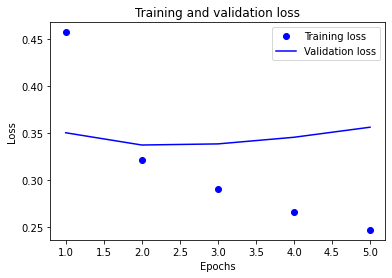

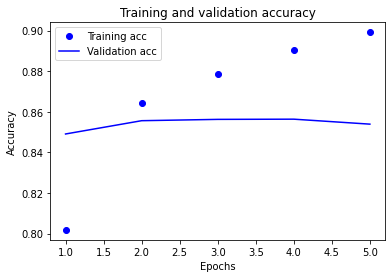

In [10]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

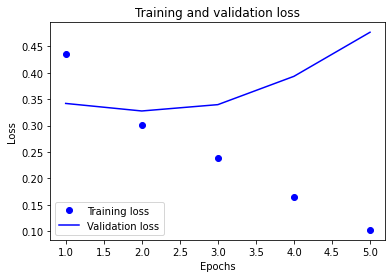

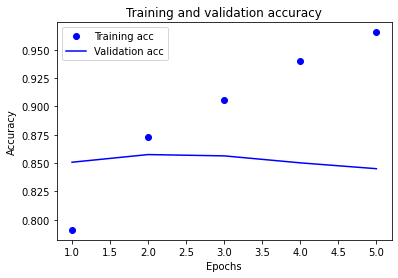

In [11]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

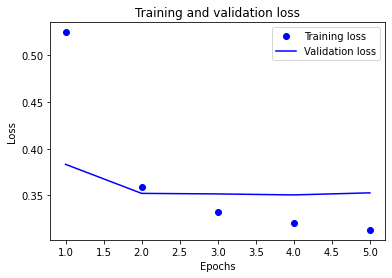

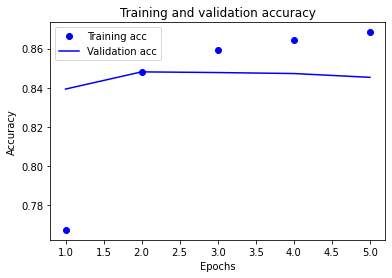

In [12]:
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [13]:
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

Pre-trained word vectors of 30+ languages

## 설치오류로 pip 버전 3.8.3으로 다운그레이드( 후 재시작 필요 !! )

In [14]:
pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
# pip install --upgrade gensim==3.8.3

from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

# 강아지랑 비슷한 단어
vector = word2vec.similar_by_word("강아지")

print(vector)


[('고양이', 0.7290452718734741), ('거위', 0.7185635566711426), ('토끼', 0.7056223154067993), ('멧돼지', 0.6950401067733765), ('엄마', 0.6934334635734558), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.6750352382659912), ('아빠', 0.6729634404182434), ('목걸이', 0.6512460708618164)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  if __name__ == '__main__':


#### embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 카피

In [16]:
word2vec = word2vec.wv # word2vec.wv대신 word2vec 사용하면 아래에서도 deprecated 경고 발생

vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 200

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

#### 임베딩 적용 후 학습

In [17]:
vocab_size = 10000
word_vector_dim = 200 #https://github.com/Kyubyong/wordvectors 참고. 한국어 word2vec는 벡터 사이즈가 200이다.

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),input_length=maxlen, trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))
lstm.summary()

# CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size,  word_vector_dim,  embeddings_initializer=Constant(embedding_matrix), input_length=maxlen,  trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))
cnn.summary()

# GlobalAveragePooling1D layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),input_length=maxlen, trainable=True))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
______________________

#### 베딩 활용하여 성능개선

In [18]:
epochs = 6
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val),                    verbose=1)

epochs = 7
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
                    


Epoch 1/6
247/247 [==============================] - 12s 43ms/step - loss: 0.5250 - accuracy: 0.7250 - val_loss: 0.3553 - val_accuracy: 0.8431
Epoch 2/6
247/247 [==============================] - 10s 40ms/step - loss: 0.3258 - accuracy: 0.8595 - val_loss: 0.3213 - val_accuracy: 0.8594
Epoch 3/6
247/247 [==============================] - 10s 40ms/step - loss: 0.2747 - accuracy: 0.8851 - val_loss: 0.3229 - val_accuracy: 0.8600
Epoch 4/6
247/247 [==============================] - 10s 40ms/step - loss: 0.2471 - accuracy: 0.8981 - val_loss: 0.3153 - val_accuracy: 0.8665
Epoch 5/6
247/247 [==============================] - 10s 40ms/step - loss: 0.2177 - accuracy: 0.9136 - val_loss: 0.3285 - val_accuracy: 0.8663
Epoch 6/6
247/247 [==============================] - 10s 40ms/step - loss: 0.1860 - accuracy: 0.9265 - val_loss: 0.3689 - val_accuracy: 0.8603
Epoch 1/7
247/247 [==============================] - 27s 99ms/step - loss: 0.8954 - accuracy: 0.5968 - val_loss: 0.4610 - val_accuracy: 0.7944

In [20]:
epochs = 10
simple.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history_simple = simple.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 20ms/step - loss: 0.3196 - accuracy: 0.8637 - val_loss: 0.3442 - val_accuracy: 0.8501
Epoch 2/10
247/247 [==============================] - 5s 19ms/step - loss: 0.3100 - accuracy: 0.8684 - val_loss: 0.3456 - val_accuracy: 0.8487
Epoch 3/10
247/247 [==============================] - 5s 19ms/step - loss: 0.3060 - accuracy: 0.8709 - val_loss: 0.3486 - val_accuracy: 0.8503
Epoch 4/10
247/247 [==============================] - 5s 19ms/step - loss: 0.3020 - accuracy: 0.8715 - val_loss: 0.3499 - val_accuracy: 0.8493
Epoch 5/10
247/247 [==============================] - 5s 19ms/step - loss: 0.2992 - accuracy: 0.8722 - val_loss: 0.3521 - val_accuracy: 0.8476
Epoch 6/10
247/247 [==============================] - 5s 19ms/step - loss: 0.2934 - accuracy: 0.8748 - val_loss: 0.3532 - val_accuracy: 0.8486
Epoch 7/10
247/247 [==============================] - 5s 19ms/step - loss: 0.2931 - accuracy: 0.8753 - val_loss: 0.3496 - val_accuracy: 0.8492

In [21]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

# GlobalAveragePooling1D layer
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

1537/1537 - 6s - loss: 0.3785 - accuracy: 0.8579
[0.37850260734558105, 0.8578839302062988]
1537/1537 - 6s - loss: 0.3431 - accuracy: 0.8513
[0.3431154191493988, 0.8512521386146545]
1537/1537 - 2s - loss: 0.3639 - accuracy: 0.8425
[0.3638652265071869, 0.8424639701843262]


## 회고

#### 1. 이번 프로젝트에서 어려웠던 점

> **한국어 Word2Vec 임베딩 활용** 부분에서 설치 후, 로딩이 안되서 시간을 많이 소비함;;



2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

>알아낸 점 : python module은 버전을 참 많이 탄다는것을 느꼈음

    
>모호한 점 : 대략적인 개념은 알겠으나, 각 소스에 대한 내용 100%를 다 알지는 못 함



3. 루브릭 평가 지표를 맞추기 위해 시도한 것들.

> 한국어 Word2Vec 임베딩 활용설치와 관련된 부분을 많이 검색함, 기존에 했던 분들의 모델을 거의 모방했음;; ㅠㅠ;

> epochs 횟수를 너무 적게 주어, 루브릭 기준에 맞출때까지 epochs 횟수를 더 높임


#### 4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정.

> Exploration에 대해서 충분한 시간을 갖고 이해하거나, 기존에 이해 못했던 부분들이 영향을 끼침

#### 5. 자기 다짐

> 오류가 발생하면 주변에 먼저 동일한 현상이 있는지를 물어봐야 겠음